<a href="https://colab.research.google.com/github/KrisMatrix/TensorFlow_Certification_Prep/blob/main/08_introduction_to_nlp_in_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to NLP fundamentals in TensorFlow

NLP has the goal of deriving information out of natural language (could be sequence text or speech). 

Another common term for NLP problems is sequence to sequence (seq2seq) problems.

# Check for GPU

In [1]:
!nvidia-smi -L

GPU 0: Tesla K80 (UUID: GPU-5c1e75e3-f81c-b059-1307-01d239deefa4)


In [2]:
# Get helper functions

!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2021-09-11 17:34:33--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-09-11 17:34:33 (46.5 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



In [3]:
# Import series of helper functions for the notebook
from helper_functions import unzip_data, create_tensorboard_callback, plot_loss_curves, compare_historys

## Get a text dataset

The dataset we're going to be using is Kaggle's intro to NLP dataset (text samples of Tweets labelled as disaster or not disaster).



In [4]:
! wget https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip

--2021-09-11 17:34:35--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.191.128, 173.194.192.128, 209.85.147.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.191.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip.1’

nlp_getting_started 100%[===================>] 593.11K  --.-KB/s    in 0.006s  

2021-09-11 17:34:35 (94.8 MB/s) - ‘nlp_getting_started.zip.1’ saved [607343/607343]



In [5]:
unzip_data("nlp_getting_started.zip")

## Visualizing a text dataset

To visualize our text samples, we first have to read them in, one way to so would be to use Python.

But I prefer to get visual straight away ...

So another way to do this is to use pandas...

In [6]:
import pandas as pd
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [7]:
train_df['text'][0]

'Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all'

In [8]:
#Shuffle training dataframe
train_df_shuffled = train_df.sample(frac=1, random_state=42)
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [9]:
# What does the test dataframe look like
test_df.head()  #just doesn't have target.

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [10]:
# How many examples of each class?
train_df.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [11]:
# How many total samples?
len(train_df), len(test_df)

(7613, 3263)

In [12]:
# Let's visualize some random training examples
import random
random_index = random.randint(0, len(train_df)-5)  #create random indexes
for row in train_df_shuffled[["text", "target"]][random_index:random_index+5].itertuples():
  _, text, target = row
  print(f"Target: {target}", "(real disaster)" if target > 0 else "(not real disaster)")
  print(f"Text:\n{text}\n")
  print("---\n")

Target: 0 (not real disaster)
Text:
https://t.co/oIfN28HpCS @ArianaGrande @ScreamQueens 
Katherine's death

---

Target: 0 (not real disaster)
Text:
Uribe demolished that ball ??????

---

Target: 0 (not real disaster)
Text:
A tornado flew around my room before you came

---

Target: 0 (not real disaster)
Text:
New Nanotech Device Will Be Able To Target And Destroy Blood Clots http://t.co/HFy5V3sLBB

---

Target: 0 (not real disaster)
Text:
Floods Fishing Finally Sunshine &amp; Fab Deals from Albertsons Anniversary Sale |Lauren Paints | a beautiful life http://t.co/CwHSLMB8x9

---



### Split data into training and validation sets

In [13]:
from sklearn.model_selection import train_test_split

In [14]:
#Use train_test_split to split training data into training and validation sets
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_shuffled["text"].to_numpy(),
                                                                           train_df_shuffled["target"].to_numpy(),
                                                                           test_size=0.1, #use 10% of training data for valid
                                                                           random_state=42)

In [15]:
# Check the lengths
len(train_sentences), len(train_labels), len(val_sentences), len(val_labels)

(6851, 6851, 762, 762)

In [16]:
# Check the first 10 samples
train_sentences[:10], train_labels[:10]

(array(['@mogacola @zamtriossu i screamed after hitting tweet',
        'Imagine getting flattened by Kurt Zouma',
        '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
        "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
        'Somehow find you and I collide http://t.co/Ee8RpOahPk',
        '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
        'destroy the free fandom honestly',
        'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
        '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
        'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt'],
       dtype=object), array([0, 

## Converting text into numbers

When dealing with a text problem, one of the first things you'll have to do before you can build a model is to convert your text to numbers.

There are a few ways to do this, namely:
* Tokenization - direct mapping of token (a token could be a word or a character) to a number.
* Embedding - create a matrix of feature vector for each token (the size of the feature vector can be defined and this embedding can be learned).

## Text vectorization (tokenization)

In [17]:
train_sentences[:5]

array(['@mogacola @zamtriossu i screamed after hitting tweet',
       'Imagine getting flattened by Kurt Zouma',
       '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
       "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
       'Somehow find you and I collide http://t.co/Ee8RpOahPk'],
      dtype=object)

In [18]:

import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
# Note: in TensorFlow 2.6+, you no longer need "layers.experimental.preprocessing"
# you can use: "tf.keras.layers.TextVectorization", see https://github.com/tensorflow/tensorflow/releases/tag/v2.6.0 for more

# Use the default TextVectorization variables
text_vectorizer = TextVectorization(max_tokens=None, # how many words in the vocabulary (all of the different words in your text)
                                    standardize="lower_and_strip_punctuation", # how to process text
                                    split="whitespace", # how to split tokens
                                    ngrams=None, # create groups of n-words?
                                    output_mode="int", # how to map tokens to numbers
                                    output_sequence_length=None) # how long should the output sequence of tokens be?
                                    # pad_to_max_tokens=True) # Not valid if using max_tokens=None

In [19]:
# Find average number of tokens (words) in training Tweets
round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))

15

In [20]:
# Setup text vectorization with custom variables
max_vocab_length = 10000 # max number of words to have in our vocabulary
max_length = 15 # max length our sequences will be (e.g. how many words from a Tweet does our model see?)

text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode="int",
                                    output_sequence_length=max_length)

In [21]:
# Fit the text vectorizer to the training text
text_vectorizer.adapt(train_sentences)

In [22]:
# Create sample sentence and tokenize it
sample_sentence = "There's a flood in my street!"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[264,   3, 232,   4,  13, 698,   0,   0,   0,   0,   0,   0,   0,
          0,   0]])>

In [23]:
# Choose a random sentence from the training dataset and tokenize it
random_sentence = random.choice(train_sentences)
print(f"Original text:\n{random_sentence}\
      \n\nVectorized version:")
text_vectorizer([random_sentence])

Original text:
70 years ago today the U.S.  dropped a nuclear weapon on Japan. Here are some articles that share my opinion on that decisionÛ_      

Vectorized version:


<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[ 325,  141,  750,  124,    2,   69, 1870,    3,  105,  263,   11,
         224,  140,   22,   82]])>

In [24]:
# Get the unique words in the vocabulary
words_in_vocab = text_vectorizer.get_vocabulary()
top_5_words = words_in_vocab[:5] # most common tokens (notice the [UNK] token for "unknown" words)
bottom_5_words = words_in_vocab[-5:] # least common tokens
print(f"Number of words in vocab: {len(words_in_vocab)}")
print(f"Top 5 most common words: {top_5_words}") 
print(f"Bottom 5 least common words: {bottom_5_words}")

Number of words in vocab: 10000
Top 5 most common words: ['', '[UNK]', 'the', 'a', 'in']
Bottom 5 least common words: ['pages', 'paeds', 'pads', 'padres', 'paddytomlinson1']


## Creating an Embedding Layer

To make our embedding, we're going to use TensorFlow's embedding layer.

The parameters we care most about for our embedding layer:
* `input_dim` = the size of our vocabulary
* `output_dim` = the size of the output embedding vector, for example, a value of 100 would mean each token gets represented by a vector 100 long
* `input_length` = length of the sequences being passed to the embedding layer.

In [25]:
from tensorflow.keras import layers

embedding = layers.Embedding(input_dim=max_vocab_length, # set input shape
                             output_dim=128, # set size of embedding vector
                             embeddings_initializer="uniform", # default, intialize randomly
                             input_length=max_length) # how long is each input

embedding

In [26]:
# Get a random sentence from training set
random_sentence = random.choice(train_sentences)
print(f"Original text:\n{random_sentence}\
      \n\nEmbedded version:")

# Embed the random sentence (turn it into numerical representation)
sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed

Original text:
Las Vegas in top 5 cities for red-light running fatalities - News3LV http://t.co/eXdbcx4gCR      

Embedded version:


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[ 0.01319343,  0.00094383,  0.03795994, ...,  0.0348247 ,
          0.003139  , -0.03008923],
        [-0.015508  ,  0.01783958,  0.00797755, ...,  0.03018178,
          0.01310921, -0.00636036],
        [-0.01723858, -0.01769469,  0.01752433, ..., -0.01777048,
         -0.03914837, -0.0111191 ],
        ...,
        [-0.0202919 , -0.03337848,  0.03656572, ..., -0.00867773,
          0.03417848,  0.03655838],
        [-0.0202919 , -0.03337848,  0.03656572, ..., -0.00867773,
          0.03417848,  0.03655838],
        [-0.0202919 , -0.03337848,  0.03656572, ..., -0.00867773,
          0.03417848,  0.03655838]]], dtype=float32)>

In [27]:
# Check out a single token's embedding
sample_embed[0][0]

<tf.Tensor: shape=(128,), dtype=float32, numpy=
array([ 0.01319343,  0.00094383,  0.03795994, -0.00682693,  0.03922417,
        0.02209156, -0.02235245,  0.03079636,  0.03805442,  0.03211553,
       -0.00625305, -0.04542823, -0.03305288,  0.03407397,  0.02714917,
       -0.01938601,  0.01698897, -0.02193478, -0.00515227,  0.03680152,
        0.02340115,  0.04924435,  0.01430732, -0.02573018, -0.00312651,
       -0.03534408,  0.04656405, -0.04553846, -0.02690182,  0.0158175 ,
       -0.04511812, -0.03867165,  0.04522375,  0.00208383, -0.01586616,
       -0.0380797 , -0.04658697, -0.0204453 , -0.04962256, -0.03824158,
        0.04544501,  0.01524505,  0.0261708 , -0.03647786,  0.03732483,
        0.03021472,  0.03670395,  0.03044648,  0.00889864, -0.0243018 ,
        0.00508133, -0.02943964,  0.03010743,  0.04013881,  0.02529824,
       -0.03436098,  0.01342917,  0.00697602, -0.00233121, -0.04524968,
        0.00116141,  0.00519135, -0.04829584, -0.0207068 ,  0.03617162,
       -0.008433

## Modelling a text dataset (running a series of experiments)

Now we've got a way to turn our text sequences into numbers, it's time to start building a series of modelling experiments.

* **Model 0:** Naive Bayes (baseline)
* **Model 1:** Feed-forward neural network (dense model)
* **Model 2:** LSTM model
* **Model 3:** GRU model
* **Model 4:** Bidirectional-LSTM model
* **Model 5:** 1D Convolutional Neural Network
* **Model 6:** TensorFlow Hub Pretrained Feature Extractor
* **Model 7:** Same as model 6 with 10% of training data

### Model 0: Getting a baseline

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create tokenization and modelling pipeline
model_0 = Pipeline([
                    ("tfidf", TfidfVectorizer()), # convert words to numbers using tfidf
                    ("clf", MultinomialNB()) # model the text
])

# Fit the pipeline to the training data
model_0.fit(train_sentences, train_labels)

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [29]:
baseline_score = model_0.score(val_sentences, val_labels)
print(f"Our baseline model achieves an accuracy of: {baseline_score*100:.2f}%")

Our baseline model achieves an accuracy of: 79.27%


In [30]:

# Make predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds[:20]

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1])

### Creating an evaluation function for our model experiements

We could evaluate these as they are but since we're going to be evaluating several models in the same way going forward, let's create a helper function which takes an array of predictions and ground truth labels and computes the following:

* Accuracy
* Precision
* Recall
* F1-score

**Note:** Since we're dealing with a classification problem, the above metrics are the most appropriate. If we were working with a regression problem, other metrics such as MAE (mean absolute error) would be a better choice.

In [31]:
# Function to evaluate: accuracy, precision, recall, f1-score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.

  Args:
  -----
  y_true = true labels in the form of a 1D array
  y_pred = predicted labels in the form of a 1D array

  Returns a dictionary of accuracy, precision, recall, f1-score.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted" average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

In [32]:
# Get baseline results
baseline_results = calculate_results(y_true=val_labels,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 79.26509186351706,
 'f1': 0.7862189758049549,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706}

### Model 1: A simple dense model

In [33]:
# Create tensorboard callback (need to create a new one for each model)
from helper_functions import create_tensorboard_callback

# Create directory to save TensorBoard logs
SAVE_DIR = "model_logs"

In [34]:

# Build model with the Functional API
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string") # inputs are 1-dimensional strings
x = text_vectorizer(inputs) # turn the input text into numbers
x = embedding(x) # create an embedding of the numerized numbers
x = layers.GlobalAveragePooling1D()(x) # lower the dimensionality of the embedding (try running the model without this layer and see what happens)
outputs = layers.Dense(1, activation="sigmoid")(x) # create the output layer, want binary outputs so use sigmoid activation
model_1 = tf.keras.Model(inputs, outputs, name="model_1_dense") # construct the model

In [35]:
# Compile model
model_1.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [36]:
# Get a summary of the model
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 15)                0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           1280000   
_________________________________________________________________
global_average_pooling1d (Gl (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 1,280,129
Trainable params: 1,280,129
Non-trainable params: 0
_________________________________________________________________


In [37]:

# Fit the model
model_1_history = model_1.fit(train_sentences, # input sentences can be a list of strings due to text preprocessing layer built-in model
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR, 
                                                                     experiment_name="simple_dense_model")])

Saving TensorBoard log files to: model_logs/simple_dense_model/20210911-173438
Epoch 1/5
215/215 [==============================] - 3s 10ms/step - loss: 0.6127 - accuracy: 0.6929 - val_loss: 0.5360 - val_accuracy: 0.7625
Epoch 2/5
215/215 [==============================] - 2s 7ms/step - loss: 0.4429 - accuracy: 0.8186 - val_loss: 0.4690 - val_accuracy: 0.7835
Epoch 3/5
215/215 [==============================] - 2s 7ms/step - loss: 0.3477 - accuracy: 0.8637 - val_loss: 0.4588 - val_accuracy: 0.7966
Epoch 4/5
215/215 [==============================] - 2s 7ms/step - loss: 0.2850 - accuracy: 0.8898 - val_loss: 0.4647 - val_accuracy: 0.7900
Epoch 5/5
215/215 [==============================] - 2s 7ms/step - loss: 0.2385 - accuracy: 0.9111 - val_loss: 0.4773 - val_accuracy: 0.7848


In [38]:
# Check the results
model_1.evaluate(val_sentences, val_labels)

24/24 [==============================] - 0s 5ms/step - loss: 0.4773 - accuracy: 0.7848


[0.47732415795326233, 0.7847769260406494]

In [39]:
# Make predictions (these come back in the form of probabilities)
model_1_pred_probs = model_1.predict(val_sentences)
model_1_pred_probs[:10] # only print out the first 10 prediction probabilities

array([[0.35021704],
       [0.7982371 ],
       [0.9979443 ],
       [0.13098286],
       [0.13528593],
       [0.94345367],
       [0.9232751 ],
       [0.9933756 ],
       [0.96714926],
       [0.299709  ]], dtype=float32)

In [40]:
# Turn prediction probabilities into single-dimension tensor of floats
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs)) # squeeze removes single dimensions
model_1_preds[:20]

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0.], dtype=float32)>

In [41]:
# Calculate model_1 metrics
model_1_results = calculate_results(y_true=val_labels, 
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 78.4776902887139,
 'f1': 0.7818959205825942,
 'precision': 0.789165199286798,
 'recall': 0.7847769028871391}

In [42]:
# Is our simple Keras model better than our baseline model?
import numpy as np
np.array(list(model_1_results.values())) > np.array(list(baseline_results.values()))

array([False, False, False, False])

In [43]:
# Create a helper function to compare our baseline results to new model results
def compare_baseline_to_new_results(baseline_results, new_model_results):
  for key, value in baseline_results.items():
    print(f"Baseline {key}: {value:.2f}, New {key}: {new_model_results[key]:.2f}, Difference: {new_model_results[key]-value:.2f}")

compare_baseline_to_new_results(baseline_results=baseline_results, 
                                new_model_results=model_1_results)

Baseline accuracy: 79.27, New accuracy: 78.48, Difference: -0.79
Baseline precision: 0.81, New precision: 0.79, Difference: -0.02
Baseline recall: 0.79, New recall: 0.78, Difference: -0.01
Baseline f1: 0.79, New f1: 0.78, Difference: -0.00


### Recurrent Neural Networks (RNN's)

RNN's are useful for sequence data.

The premise of a RNN is to use the representation of a previous input to aid the representation of a later input.

### Model 2: LSTM

LSTM = Long Short Term Memory (one of the most popular RNNs)

Our structure of an RNN typically looks like this:

```
Input (text) -> Tokenize -> Embedding -> Layers (RNNs/dense) -> Output (label probability)
```

In [44]:
# Create an LSTM model
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
print(x.shape)
x = layers.LSTM(64, return_sequences=True)(x)
print(x.shape)
x = layers.LSTM(64)(x)
print(x.shape)
x = layers.Dense(64, activation="relu")(x)
print(x.shape)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_2 = tf.keras.Model(inputs, outputs, name="model_2_LSTM")

(None, 15, 128)
(None, 15, 64)
(None, 64)
(None, 64)


In [45]:
model_2.summary()

Model: "model_2_LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 15)                0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           1280000   
_________________________________________________________________
lstm (LSTM)                  (None, 15, 64)            49408     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                

In [46]:
# Compile the model
model_2.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [47]:
#$ Fit the model
model_2_history = model_2.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "model_2_LSTM")])

Saving TensorBoard log files to: model_logs/model_2_LSTM/20210911-173449
Epoch 1/5
215/215 [==============================] - 9s 23ms/step - loss: 0.2240 - accuracy: 0.9253 - val_loss: 0.6563 - val_accuracy: 0.7756
Epoch 2/5
215/215 [==============================] - 3s 15ms/step - loss: 0.1564 - accuracy: 0.9407 - val_loss: 0.6144 - val_accuracy: 0.7861
Epoch 3/5
215/215 [==============================] - 3s 16ms/step - loss: 0.1341 - accuracy: 0.9470 - val_loss: 0.7438 - val_accuracy: 0.7795
Epoch 4/5
215/215 [==============================] - 4s 17ms/step - loss: 0.1071 - accuracy: 0.9600 - val_loss: 0.7783 - val_accuracy: 0.7756
Epoch 5/5
215/215 [==============================] - 3s 16ms/step - loss: 0.0861 - accuracy: 0.9642 - val_loss: 0.8782 - val_accuracy: 0.7703


In [48]:
# Make predictions with LSTM model
model_2_pred_probs = model_2.predict(val_sentences)
model_2_pred_probs[:10]

array([[9.9339634e-02],
       [9.2917091e-01],
       [9.9997211e-01],
       [9.8332778e-02],
       [2.6101753e-04],
       [9.9942845e-01],
       [9.3365002e-01],
       [9.9998045e-01],
       [9.9996173e-01],
       [4.4676340e-01]], dtype=float32)

In [49]:
# Convert model 2 pred probs to labels
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))
model_2_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [50]:
# Calculate model 2 results
model_2_results = calculate_results(y_true=val_labels,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 77.03412073490814,
 'f1': 0.7680604812955161,
 'precision': 0.7723473976820748,
 'recall': 0.7703412073490814}

In [51]:
baseline_results

{'accuracy': 79.26509186351706,
 'f1': 0.7862189758049549,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706}

### Model 3: GRU

Another popular and effective RNN component is the GRU (gated recurrent unit).

The GRU cell has similar features to an LSTM cell but has less parameters.

In [52]:
# Build an RNN using the GRU cell
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
print(x.shape)
x = layers.GRU(64, return_sequences=True)(x) #if you want to stack recurrent layers 
print(x.shape)
x = layers.LSTM(42, return_sequences=True)(x)
print(x.shape)
x = layers.GRU(99, return_sequences=True)(x)
print(x.shape)
x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_3 = tf.keras.Model(inputs, outputs, name="model_3_GRU")

(None, 15, 128)
(None, 15, 64)
(None, 15, 42)
(None, 15, 99)


In [53]:
model_3.summary()

Model: "model_3_GRU"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 15)                0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           1280000   
_________________________________________________________________
gru (GRU)                    (None, 15, 64)            37248     
_________________________________________________________________
lstm_2 (LSTM)                (None, 15, 42)            17976     
_________________________________________________________________
gru_1 (GRU)                  (None, 15, 99)            42471     
_________________________________________________________________
dense_3 (Dense)              (None, 15, 64)            

In [54]:
# Build an RNN using the GRU cell
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
# x = layers.GRU(64, return_sequences=True) # stacking recurrent cells requires return_sequences=True
x = layers.GRU(64)(x) 
# x = layers.Dense(64, activation="relu")(x) # optional dense layer after GRU cell
outputs = layers.Dense(1, activation="sigmoid")(x)
model_3 = tf.keras.Model(inputs, outputs, name="model_3_GRU")

In [55]:
# Compile GRU model
model_3.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [56]:
# Get a summary of the GRU model
model_3.summary()

Model: "model_3_GRU"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 15)                0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           1280000   
_________________________________________________________________
gru_2 (GRU)                  (None, 64)                37248     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 1,317,313
Trainable params: 1,317,313
Non-trainable params: 0
_________________________________________________________________


In [57]:
# Fit model
model_3_history = model_3.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "GRU")])

Saving TensorBoard log files to: model_logs/GRU/20210911-173515
Epoch 1/5
215/215 [==============================] - 5s 15ms/step - loss: 0.1632 - accuracy: 0.9349 - val_loss: 0.8848 - val_accuracy: 0.7835
Epoch 2/5
215/215 [==============================] - 2s 11ms/step - loss: 0.0829 - accuracy: 0.9693 - val_loss: 0.8627 - val_accuracy: 0.7782
Epoch 3/5
215/215 [==============================] - 2s 10ms/step - loss: 0.0733 - accuracy: 0.9720 - val_loss: 1.1284 - val_accuracy: 0.7743
Epoch 4/5
215/215 [==============================] - 2s 10ms/step - loss: 0.0631 - accuracy: 0.9746 - val_loss: 0.9815 - val_accuracy: 0.7717
Epoch 5/5
215/215 [==============================] - 2s 10ms/step - loss: 0.0544 - accuracy: 0.9777 - val_loss: 0.9994 - val_accuracy: 0.7677


In [58]:
# Make predictions on the validation data
model_3_pred_probs = model_3.predict(val_sentences)
model_3_pred_probs.shape, model_3_pred_probs[:10]

((762, 1), array([[2.18530111e-02],
        [8.05039167e-01],
        [9.99637127e-01],
        [4.92835306e-02],
        [1.18385295e-04],
        [9.98555958e-01],
        [7.39506543e-01],
        [9.99873757e-01],
        [9.99724567e-01],
        [8.10471356e-01]], dtype=float32))

In [59]:
# Convert prediction probabilities to prediction classes
model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))
model_3_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [60]:
# Calcuate model_3 results
model_3_results = calculate_results(y_true=val_labels, 
                                    y_pred=model_3_preds)
model_3_results

{'accuracy': 76.77165354330708,
 'f1': 0.7660466459325422,
 'precision': 0.768489862704666,
 'recall': 0.7677165354330708}

In [61]:
# Compare to baseline
compare_baseline_to_new_results(baseline_results, model_3_results)

Baseline accuracy: 79.27, New accuracy: 76.77, Difference: -2.49
Baseline precision: 0.81, New precision: 0.77, Difference: -0.04
Baseline recall: 0.79, New recall: 0.77, Difference: -0.02
Baseline f1: 0.79, New f1: 0.77, Difference: -0.02


### Model 4: Bidirectional RNN

Normal RNN's go from left to right (just like you'd read an English sentence) however, a bidirectional RNN goes from right to left and then left to right.

In [62]:

# Build a Bidirectional RNN in TensorFlow
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
# x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x) # stacking RNN layers requires return_sequences=True
x = layers.Bidirectional(layers.LSTM(64))(x) # bidirectional goes both ways so has double the parameters of a regular LSTM layer
outputs = layers.Dense(1, activation="sigmoid")(x)
model_4 = tf.keras.Model(inputs, outputs, name="model_4_Bidirectional")

In [63]:
# Get a summary
model_4.summary()

Model: "model_4_Bidirectional"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 15)                0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           1280000   
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               98816     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 129       
Total params: 1,378,945
Trainable params: 1,378,945
Non-trainable params: 0
_________________________________________________________________


In [64]:
# Compile
model_4.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [65]:
# Fit the model (takes longer because of the bidirectional layers)
model_4_history = model_4.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "bidirectional_RNN")])

Saving TensorBoard log files to: model_logs/bidirectional_RNN/20210911-173540
Epoch 1/5
215/215 [==============================] - 8s 22ms/step - loss: 0.1047 - accuracy: 0.9683 - val_loss: 0.9023 - val_accuracy: 0.7677
Epoch 2/5
215/215 [==============================] - 3s 15ms/step - loss: 0.0555 - accuracy: 0.9762 - val_loss: 1.1813 - val_accuracy: 0.7717
Epoch 3/5
215/215 [==============================] - 3s 15ms/step - loss: 0.0471 - accuracy: 0.9793 - val_loss: 1.2853 - val_accuracy: 0.7651
Epoch 4/5
215/215 [==============================] - 3s 15ms/step - loss: 0.0424 - accuracy: 0.9806 - val_loss: 1.4854 - val_accuracy: 0.7717
Epoch 5/5
215/215 [==============================] - 3s 15ms/step - loss: 0.0390 - accuracy: 0.9809 - val_loss: 1.2882 - val_accuracy: 0.7638


In [66]:
# Make predictions with bidirectional RNN on the validation data
model_4_pred_probs = model_4.predict(val_sentences)
model_4_pred_probs[:10]

array([[1.6242123e-01],
       [4.9429074e-01],
       [9.9986494e-01],
       [2.7092355e-01],
       [9.7317625e-06],
       [9.9823511e-01],
       [9.0722620e-01],
       [9.9996924e-01],
       [9.9990118e-01],
       [9.5124269e-01]], dtype=float32)

In [67]:
# Convert prediction probabilities to labels
model_4_preds = tf.squeeze(tf.round(model_4_pred_probs))
model_4_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 0., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [68]:
# Calculate bidirectional RNN model results
model_4_results = calculate_results(val_labels, model_4_preds)
model_4_results

{'accuracy': 76.37795275590551,
 'f1': 0.7621412379223811,
 'precision': 0.764383846466808,
 'recall': 0.7637795275590551}

In [69]:

# Check to see how the bidirectional model performs against the baseline
compare_baseline_to_new_results(baseline_results, model_4_results)

Baseline accuracy: 79.27, New accuracy: 76.38, Difference: -2.89
Baseline precision: 0.81, New precision: 0.76, Difference: -0.05
Baseline recall: 0.79, New recall: 0.76, Difference: -0.03
Baseline f1: 0.79, New f1: 0.76, Difference: -0.02


### Model 5: Conv1D

In [70]:
# Test out the embedding, 1D convolutional and max pooling
embedding_test = embedding(text_vectorizer(["this is a test sentence"])) # turn target sentence into embedding
conv_1d = layers.Conv1D(filters=32, kernel_size=5, activation="relu") # convolve over target sequence 5 words at a time
conv_1d_output = conv_1d(embedding_test) # pass embedding through 1D convolutional layer
max_pool = layers.GlobalMaxPool1D() 
max_pool_output = max_pool(conv_1d_output) # get the most important features
embedding_test.shape, conv_1d_output.shape, max_pool_output.shape

(TensorShape([1, 15, 128]), TensorShape([1, 11, 32]), TensorShape([1, 32]))

In [71]:
# See the outputs of each layer
embedding_test[:1], conv_1d_output[:1], max_pool_output[:1]

(<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
 array([[[-0.04295464, -0.07922305, -0.00141772, ...,  0.06309047,
           0.01911005, -0.03969366],
         [-0.00615895, -0.01854176,  0.0359186 , ...,  0.02487346,
          -0.01062937, -0.0153396 ],
         [-0.00706388, -0.05419252, -0.04991948, ...,  0.03339707,
           0.00937139,  0.00433444],
         ...,
         [-0.03707583, -0.03461448,  0.02817286, ...,  0.00554966,
           0.02717419,  0.03391589],
         [-0.03707583, -0.03461448,  0.02817286, ...,  0.00554966,
           0.02717419,  0.03391589],
         [-0.03707583, -0.03461448,  0.02817286, ...,  0.00554966,
           0.02717419,  0.03391589]]], dtype=float32)>,
 <tf.Tensor: shape=(1, 11, 32), dtype=float32, numpy=
 array([[[0.07754969, 0.11555281, 0.05015389, 0.04523728, 0.        ,
          0.1217972 , 0.        , 0.        , 0.07092075, 0.04234728,
          0.        , 0.0023914 , 0.        , 0.        , 0.        ,
          0.03266478, 0.

In [72]:
# Create 1-dimensional convolutional layer to model sequences
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Conv1D(filters=32, kernel_size=5, activation="relu")(x)
x = layers.GlobalMaxPool1D()(x)
# x = layers.Dense(64, activation="relu")(x) # optional dense layer
outputs = layers.Dense(1, activation="sigmoid")(x)
model_5 = tf.keras.Model(inputs, outputs, name="model_5_Conv1D")

# Compile Conv1D model
model_5.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Get a summary of our 1D convolution model
model_5.summary()

Model: "model_5_Conv1D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 15)                0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           1280000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 11, 32)            20512     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 32)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 33        
Total params: 1,300,545
Trainable params: 1,300,545
Non-trainable params: 0
__________________________________________

In [73]:
# Fit the model
model_5_history = model_5.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, 
                                                                     "Conv1D")])

Saving TensorBoard log files to: model_logs/Conv1D/20210911-173624
Epoch 1/5
215/215 [==============================] - 4s 11ms/step - loss: 0.1388 - accuracy: 0.9555 - val_loss: 0.8444 - val_accuracy: 0.7651
Epoch 2/5
215/215 [==============================] - 2s 8ms/step - loss: 0.0779 - accuracy: 0.9699 - val_loss: 0.9860 - val_accuracy: 0.7559
Epoch 3/5
215/215 [==============================] - 2s 8ms/step - loss: 0.0626 - accuracy: 0.9768 - val_loss: 1.0982 - val_accuracy: 0.7664
Epoch 4/5
215/215 [==============================] - 2s 8ms/step - loss: 0.0557 - accuracy: 0.9778 - val_loss: 1.1223 - val_accuracy: 0.7585
Epoch 5/5
215/215 [==============================] - 2s 8ms/step - loss: 0.0503 - accuracy: 0.9787 - val_loss: 1.1703 - val_accuracy: 0.7598


In [74]:
# Make predictions with model_5
model_5_pred_probs = model_5.predict(val_sentences)
model_5_pred_probs[:10]

array([[4.4978055e-01],
       [9.6126348e-01],
       [9.9986434e-01],
       [5.7888720e-02],
       [2.1863620e-07],
       [9.9660337e-01],
       [9.9040866e-01],
       [9.9999571e-01],
       [9.9999976e-01],
       [9.3614376e-01]], dtype=float32)

In [75]:
# Convert model_5 prediction probabilities to labels
model_5_preds = tf.squeeze(tf.round(model_5_pred_probs))
model_5_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [76]:

# Calculate model_5 evaluation metrics 
model_5_results = calculate_results(y_true=val_labels, 
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 75.98425196850394,
 'f1': 0.7589841599505696,
 'precision': 0.7595269214829928,
 'recall': 0.7598425196850394}

In [77]:
# Compare model_5 results to baseline 
compare_baseline_to_new_results(baseline_results, model_5_results)

Baseline accuracy: 79.27, New accuracy: 75.98, Difference: -3.28
Baseline precision: 0.81, New precision: 0.76, Difference: -0.05
Baseline recall: 0.79, New recall: 0.76, Difference: -0.03
Baseline f1: 0.79, New f1: 0.76, Difference: -0.03


### Model 6: Tensorflow Hub Pretrained Sentence Encoder

In [78]:
# Example of pretrained embedding with universal sentence encoder - https://tfhub.dev/google/universal-sentence-encoder/4
import tensorflow_hub as hub
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4") # load Universal Sentence Encoder
embed_samples = embed([sample_sentence,
                      "When you call the universal sentence encoder on a sentence, it turns it into numbers."])

print(embed_samples[0][:50])

tf.Tensor(
[-0.01157024  0.0248591   0.0287805  -0.01271502  0.03971543  0.08827759
  0.02680986  0.05589837 -0.01068731 -0.0059729   0.00639324 -0.01819523
  0.00030817  0.09105891  0.05874644 -0.03180627  0.01512476 -0.05162928
  0.00991369 -0.06865346 -0.04209306  0.0267898   0.03011008  0.00321069
 -0.00337969 -0.04787359  0.02266718 -0.00985924 -0.04063614 -0.01292095
 -0.04666384  0.056303   -0.03949255  0.00517685  0.02495828 -0.07014439
  0.02871508  0.04947682 -0.00633971 -0.08960191  0.02807117 -0.00808362
 -0.01360601  0.05998649 -0.10361786 -0.05195372  0.00232955 -0.02332528
 -0.03758105  0.0332773 ], shape=(50,), dtype=float32)


In [79]:
# Each sentence has been encoded into a 512 dimension vector
embed_samples[0].shape

TensorShape([512])

In [80]:

# We can use this encoding layer in place of our text_vectorizer and embedding layer
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[], # shape of inputs coming to our model 
                                        dtype=tf.string, # data type of inputs coming to the USE layer
                                        trainable=False, # keep the pretrained weights (we'll create a feature extractor)
                                        name="USE")

In [81]:

# Create model using the Sequential API
model_6 = tf.keras.Sequential([
  sentence_encoder_layer, # take in sentences and then encode them into an embedding
  layers.Dense(64, activation="relu"),
  layers.Dense(1, activation="sigmoid")
], name="model_6_USE")

# Compile model
model_6.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_6.summary()

Model: "model_6_USE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
USE (KerasLayer)             (None, 512)               256797824 
_________________________________________________________________
dense_8 (Dense)              (None, 64)                32832     
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 65        
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [82]:
# Train a classifier on top of pretrained embeddings
model_6_history = model_6.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, 
                                                                     "tf_hub_sentence_encoder")])

Saving TensorBoard log files to: model_logs/tf_hub_sentence_encoder/20210911-174322
Epoch 1/5
215/215 [==============================] - 10s 33ms/step - loss: 0.5066 - accuracy: 0.7879 - val_loss: 0.4495 - val_accuracy: 0.8005
Epoch 2/5
215/215 [==============================] - 4s 20ms/step - loss: 0.4147 - accuracy: 0.8159 - val_loss: 0.4381 - val_accuracy: 0.8084
Epoch 3/5
215/215 [==============================] - 4s 20ms/step - loss: 0.4021 - accuracy: 0.8228 - val_loss: 0.4347 - val_accuracy: 0.8071
Epoch 4/5
215/215 [==============================] - 4s 20ms/step - loss: 0.3941 - accuracy: 0.8235 - val_loss: 0.4299 - val_accuracy: 0.8110
Epoch 5/5
215/215 [==============================] - 4s 20ms/step - loss: 0.3869 - accuracy: 0.8298 - val_loss: 0.4300 - val_accuracy: 0.8097


In [83]:
# Make predictions with USE TF Hub model
model_6_pred_probs = model_6.predict(val_sentences)
model_6_pred_probs[:10]

array([[0.16365956],
       [0.77393377],
       [0.9887193 ],
       [0.21503244],
       [0.7107343 ],
       [0.745682  ],
       [0.9765603 ],
       [0.9767892 ],
       [0.94438493],
       [0.10920196]], dtype=float32)

In [84]:
# Convert prediction probabilities to labels
model_6_preds = tf.squeeze(tf.round(model_6_pred_probs))
model_6_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [85]:
# Calculate model 6 performance metrics
model_6_results = calculate_results(val_labels, model_6_preds)
model_6_results

{'accuracy': 80.97112860892388,
 'f1': 0.8081431756423573,
 'precision': 0.8118825131433668,
 'recall': 0.8097112860892388}

In [86]:
# Compare TF Hub model to baseline
compare_baseline_to_new_results(baseline_results, model_6_results)

Baseline accuracy: 79.27, New accuracy: 80.97, Difference: 1.71
Baseline precision: 0.81, New precision: 0.81, Difference: 0.00
Baseline recall: 0.79, New recall: 0.81, Difference: 0.02
Baseline f1: 0.79, New f1: 0.81, Difference: 0.02


### Model 7: TensorFlow Hub Pretrained Sentence Encoder 10% of the training data

In [87]:
### NOTE: Making splits like this will lead to data leakage ###
### (some of the training examples in the validation set) ###

### WRONG WAY TO MAKE SPLITS (train_df_shuffled has already been split) ### 

# # Create subsets of 10% of the training data
# train_10_percent = train_df_shuffled[["text", "target"]].sample(frac=0.1, random_state=42)
# train_sentences_10_percent = train_10_percent["text"].to_list()
# train_labels_10_percent = train_10_percent["target"].to_list()
# len(train_sentences_10_percent), len(train_labels_10_percent)

In [88]:

# One kind of correct way (there are more) to make data subset
# (split the already split train_sentences/train_labels)
train_sentences_90_percent, train_sentences_10_percent, train_labels_90_percent, train_labels_10_percent = train_test_split(np.array(train_sentences),
                                                                                                                            train_labels,
                                                                                                                            test_size=0.1,
                                                                                                                            random_state=42)

In [89]:

# Check length of 10 percent datasets
print(f"Total training examples: {len(train_sentences)}")
print(f"Length of 10% training examples: {len(train_sentences_10_percent)}")

Total training examples: 6851
Length of 10% training examples: 686


In [90]:
# Check the number of targets in our subset of data 
# (this should be close to the distribution of labels in the original train_labels)
pd.Series(train_labels_10_percent).value_counts()

0    415
1    271
dtype: int64

In [91]:

# Clone model_6 but reset weights
model_7 = tf.keras.models.clone_model(model_6)

# Compile model
model_7.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Get a summary (will be same as model_6)
model_7.summary()

Model: "model_6_USE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
USE (KerasLayer)             (None, 512)               256797824 
_________________________________________________________________
dense_8 (Dense)              (None, 64)                32832     
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 65        
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [92]:
# Fit the model to 10% of the training data
model_7_history = model_7.fit(x=train_sentences_10_percent,
                              y=train_labels_10_percent,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "10_percent_tf_hub_sentence_encoder")])

Saving TensorBoard log files to: model_logs/10_percent_tf_hub_sentence_encoder/20210911-175840
Epoch 1/5
22/22 [==============================] - 6s 149ms/step - loss: 0.6704 - accuracy: 0.6808 - val_loss: 0.6478 - val_accuracy: 0.7270
Epoch 2/5
22/22 [==============================] - 1s 37ms/step - loss: 0.5940 - accuracy: 0.8090 - val_loss: 0.5878 - val_accuracy: 0.7507
Epoch 3/5
22/22 [==============================] - 1s 37ms/step - loss: 0.5141 - accuracy: 0.8222 - val_loss: 0.5293 - val_accuracy: 0.7690
Epoch 4/5
22/22 [==============================] - 1s 50ms/step - loss: 0.4488 - accuracy: 0.8280 - val_loss: 0.5016 - val_accuracy: 0.7677
Epoch 5/5
22/22 [==============================] - 1s 49ms/step - loss: 0.4052 - accuracy: 0.8324 - val_loss: 0.4868 - val_accuracy: 0.7782


In [93]:
# Make predictions with the model trained on 10% of the data
model_7_pred_probs = model_7.predict(val_sentences)
model_7_pred_probs[:10]

array([[0.28014734],
       [0.78759825],
       [0.91473943],
       [0.31331077],
       [0.5389464 ],
       [0.8502201 ],
       [0.82950115],
       [0.8693915 ],
       [0.84499204],
       [0.12743546]], dtype=float32)

In [94]:
# Convert prediction probabilities to labels
model_7_preds = tf.squeeze(tf.round(model_7_pred_probs))
model_7_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [95]:
# Calculate model results
model_7_results = calculate_results(val_labels, model_7_preds)
model_7_results

{'accuracy': 77.82152230971128,
 'f1': 0.7748637513129987,
 'precision': 0.7833771178803304,
 'recall': 0.7782152230971129}

In [96]:
# Compare to baseline
compare_baseline_to_new_results(baseline_results, model_7_results)

Baseline accuracy: 79.27, New accuracy: 77.82, Difference: -1.44
Baseline precision: 0.81, New precision: 0.78, Difference: -0.03
Baseline recall: 0.79, New recall: 0.78, Difference: -0.01
Baseline f1: 0.79, New f1: 0.77, Difference: -0.01


### Comparing the performance of each of our models

In [98]:
# Combine model results into a DataFrame
all_model_results = pd.DataFrame({"baseline": baseline_results,
                                  "simple_dense": model_1_results,
                                  "lstm": model_2_results,
                                  "gru": model_3_results,
                                  "bidirectional": model_4_results,
                                  "conv1d": model_5_results,
                                  "tf_hub_sentence_encoder": model_6_results,
                                  "tf_hub_10_percent_data": model_7_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
baseline,79.265092,0.811139,0.792651,0.786219
simple_dense,78.477690,0.789165,0.784777,0.781896
lstm,77.034121,0.772347,0.770341,0.768060
gru,76.771654,0.768490,0.767717,0.766047
bidirectional,76.377953,0.764384,0.763780,0.762141
conv1d,75.984252,0.759527,0.759843,0.758984
tf_hub_sentence_encoder,80.971129,0.811883,0.809711,0.808143
tf_hub_10_percent_data,77.821522,0.783377,0.778215,0.774864


In [99]:
# Reduce the accuracy to same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100

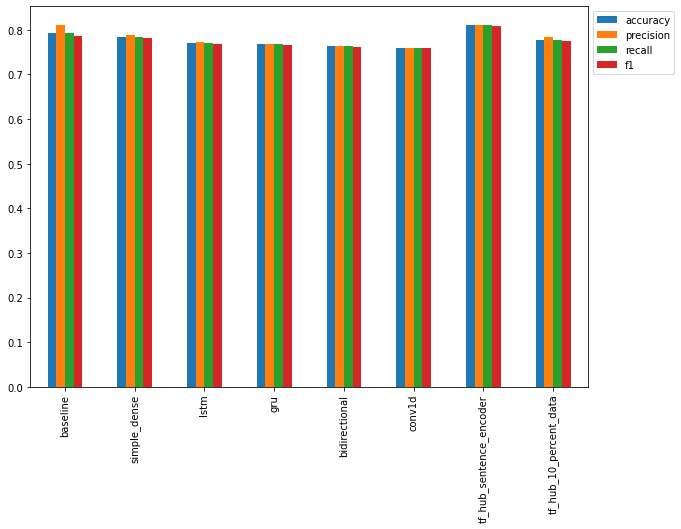

In [100]:
# Plot and compare all of the model results
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

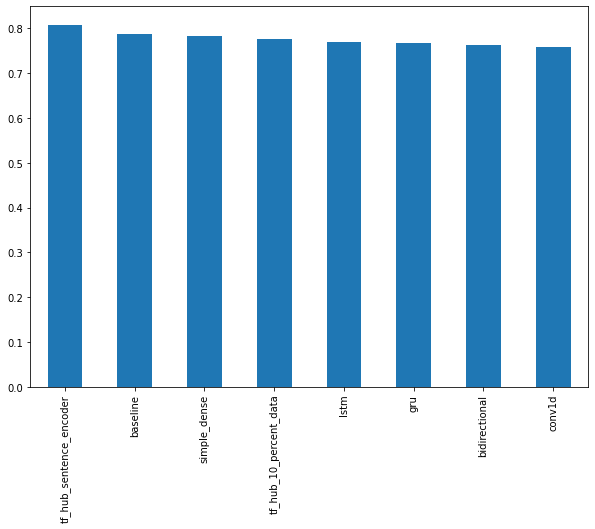

In [101]:
# Sort model results by f1-score
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10, 7));

In [102]:
# # View tensorboard logs of transfer learning modelling experiments (should be 4 models)
# # Upload TensorBoard dev records
# !tensorboard dev upload --logdir ./model_logs \
#   --name "NLP modelling experiments" \
#   --description "A series of different NLP modellings experiments with various models" \
#   --one_shot # exits the uploader when upload has finished

In [103]:
# If you need to remove previous experiments, you can do so using the following command
# !tensorboard dev delete --experiment_id EXPERIMENT_ID_TO_DELETE

### Combining our models (model ensembling/stacking)

In [104]:
# Get mean pred probs for 3 models
baseline_pred_probs = np.max(model_0.predict_proba(val_sentences), axis=1) # get the prediction probabilities from baseline model
combined_pred_probs = baseline_pred_probs + tf.squeeze(model_2_pred_probs, axis=1) + tf.squeeze(model_6_pred_probs)
combined_preds = tf.round(combined_pred_probs/3) # average and round the prediction probabilities to get prediction classes
combined_preds[:20]

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 1., 0., 0., 0.,
       0., 0., 1.], dtype=float32)>

In [105]:
# Calculate results from averaging the prediction probabilities
ensemble_results = calculate_results(val_labels, combined_preds)
ensemble_results

{'accuracy': 79.65879265091863,
 'f1': 0.7962881430926292,
 'precision': 0.7963229487220014,
 'recall': 0.7965879265091863}

In [106]:
# Add our combined model's results to the results DataFrame
all_model_results.loc["ensemble_results"] = ensemble_results

In [107]:
# Convert the accuracy to the same scale as the rest of the results
all_model_results.loc["ensemble_results"]["accuracy"] = all_model_results.loc["ensemble_results"]["accuracy"]/100

In [108]:
all_model_results


,accuracy,precision,recall,f1
baseline,0.792651,0.811139,0.792651,0.786219
simple_dense,0.784777,0.789165,0.784777,0.781896
lstm,0.770341,0.772347,0.770341,0.768060
gru,0.767717,0.768490,0.767717,0.766047
bidirectional,0.763780,0.764384,0.763780,0.762141
conv1d,0.759843,0.759527,0.759843,0.758984
tf_hub_sentence_encoder,0.809711,0.811883,0.809711,0.808143
tf_hub_10_percent_data,0.778215,0.783377,0.778215,0.774864
ensemble_results,0.796588,0.796323,0.796588,0.796288


### Saving and loading a trained model

In [109]:
# Save TF Hub Sentence Encoder model to HDF5 format
model_6.save("model_6.h5")

In [110]:
# Load model with custom Hub Layer (required with HDF5 format)
loaded_model_6 = tf.keras.models.load_model("model_6.h5", 
                                            custom_objects={"KerasLayer": hub.KerasLayer})


In [111]:
# How does our loaded model perform?
loaded_model_6.evaluate(val_sentences, val_labels)

24/24 [==============================] - 1s 17ms/step - loss: 0.4300 - accuracy: 0.8097


[0.4299670159816742, 0.8097112774848938]

In [112]:
# Save TF Hub Sentence Encoder model to SavedModel format (default)
model_6.save("model_6_SavedModel_format")

INFO:tensorflow:Assets written to: model_6_SavedModel_format/assets


INFO:tensorflow:Assets written to: model_6_SavedModel_format/assets


In [113]:
# Load TF Hub Sentence Encoder SavedModel
loaded_model_6_SavedModel = tf.keras.models.load_model("model_6_SavedModel_format")

In [114]:

# Evaluate loaded SavedModel format
loaded_model_6_SavedModel.evaluate(val_sentences, val_labels)

24/24 [==============================] - 1s 18ms/step - loss: 0.4300 - accuracy: 0.8097


[0.4299669563770294, 0.8097112774848938]

### Finding the most wrong examples

In [115]:

# Create dataframe with validation sentences and best performing model predictions
val_df = pd.DataFrame({"text": val_sentences,
                       "target": val_labels,
                       "pred": model_6_preds,
                       "pred_prob": tf.squeeze(model_6_pred_probs)})
val_df.head()

,text,target,pred,pred_prob
0,DFR EP016 Monthly Meltdown - On Dnbheaven 2015...,0,0.0,0.163660
1,FedEx no longer to transport bioterror germs i...,0,1.0,0.773934
2,Gunmen kill four in El Salvador bus attack: Su...,1,1.0,0.988719
3,@camilacabello97 Internally and externally scr...,1,0.0,0.215032
4,Radiation emergency #preparedness starts with ...,1,1.0,0.710734


In [116]:
# Find the wrong predictions and sort by prediction probabilities
most_wrong = val_df[val_df["target"] != val_df["pred"]].sort_values("pred_prob", ascending=False)
most_wrong[:10]

,text,target,pred,pred_prob
31,? High Skies - Burning Buildings ? http://t.co...,0,1.0,0.915115
759,FedEx will no longer transport bioterror patho...,0,1.0,0.885450
628,@noah_anyname That's where the concentration c...,0,1.0,0.872673
49,@madonnamking RSPCA site multiple 7 story high...,0,1.0,0.864359
209,Ashes 2015: AustraliaÛªs collapse at Trent Br...,0,1.0,0.836204
393,@SonofLiberty357 all illuminated by the bright...,0,1.0,0.827738
381,Deaths 3 http://t.co/nApviyGKYK,0,1.0,0.816379
251,@AshGhebranious civil rights continued in the ...,0,1.0,0.815652
109,[55436] 1950 LIONEL TRAINS SMOKE LOCOMOTIVES W...,0,1.0,0.809360
698,åÈMGN-AFRICAå¨ pin:263789F4 åÈ Correction: Ten...,0,1.0,0.790081


In [117]:

# Check the false positives (model predicted 1 when should've been 0)
for row in most_wrong[:10].itertuples(): # loop through the top 10 rows (change the index to view different rows)
  _, text, target, pred, prob = row
  print(f"Target: {target}, Pred: {int(pred)}, Prob: {prob}")
  print(f"Text:\n{text}\n")
  print("----\n")

Target: 0, Pred: 1, Prob: 0.915115475654602
Text:
? High Skies - Burning Buildings ? http://t.co/uVq41i3Kx2 #nowplaying

----

Target: 0, Pred: 1, Prob: 0.8854497075080872
Text:
FedEx will no longer transport bioterror pathogens in wake of anthrax lab mishaps http://t.co/lHpgxc4b8J

----

Target: 0, Pred: 1, Prob: 0.8726726770401001
Text:
@noah_anyname That's where the concentration camps and mass murder come in. 
 
EVERY. FUCKING. TIME.

----

Target: 0, Pred: 1, Prob: 0.8643589615821838
Text:
@madonnamking RSPCA site multiple 7 story high rise buildings next to low density character residential in an area that floods

----

Target: 0, Pred: 1, Prob: 0.8362041711807251
Text:
Ashes 2015: AustraliaÛªs collapse at Trent Bridge among worst in history: England bundled out Australia for 60 ... http://t.co/t5TrhjUAU0

----

Target: 0, Pred: 1, Prob: 0.8277379870414734
Text:
@SonofLiberty357 all illuminated by the brightly burning buildings all around the town!

----

Target: 0, Pred: 1, Pro

In [118]:
# Check the most wrong false negatives (model predicted 0 when should've predict 1)
for row in most_wrong[-10:].itertuples():
  _, text, target, pred, prob = row
  print(f"Target: {target}, Pred: {int(pred)}, Prob: {prob}")
  print(f"Text:\n{text}\n")
  print("----\n")

Target: 1, Pred: 0, Prob: 0.05802590399980545
Text:
going to redo my nails and watch behind the scenes of desolation of smaug ayyy

----

Target: 1, Pred: 0, Prob: 0.05772469937801361
Text:
'The way you move is like a full on rainstorm and I'm a house of cards'

----

Target: 1, Pred: 0, Prob: 0.053100474178791046
Text:
@willienelson We need help! Horses will die!Please RT &amp; sign petition!Take a stand &amp; be a voice for them! #gilbert23 https://t.co/e8dl1lNCVu

----

Target: 1, Pred: 0, Prob: 0.049916964024305344
Text:
Lucas Duda is Ghost Rider. Not the Nic Cage version but an actual 'engulfed in flames' badass. #Mets

----

Target: 1, Pred: 0, Prob: 0.04905632883310318
Text:
You can never escape me. Bullets don't harm me. Nothing harms me. But I know pain. I know pain. Sometimes I share it. With someone like you.

----

Target: 1, Pred: 0, Prob: 0.047832705080509186
Text:
I get to smoke my shit in peace

----

Target: 1, Pred: 0, Prob: 0.04149486869573593
Text:
@SoonerMagic_ I m

### Making predictions on the test dataset

In [119]:
# Making predictions on the test dataset
test_sentences = test_df["text"].to_list()
test_samples = random.sample(test_sentences, 10)
for test_sample in test_samples:
  pred_prob = tf.squeeze(model_6.predict([test_sample])) # has to be list
  pred = tf.round(pred_prob)
  print(f"Pred: {int(pred)}, Prob: {pred_prob}")
  print(f"Text:\n{test_sample}\n")
  print("----\n")

Pred: 0, Prob: 0.12759782373905182
Text:
Pissed something off in the wood pile. Pulling pieces out and I get a small hiss and a series of low clicks for my trouble.

----

Pred: 1, Prob: 0.9826521873474121
Text:
@Ramdog1980 Israeli soldiers demolished a residential shed and a barn. Soldiers also demolished a shed in Beit Kahel northwest of Hebron.

----

Pred: 1, Prob: 0.9670974612236023
Text:
http://t.co/Dg0EcBYKJL Tornado warnings end after thunderstorms hammer Calgary region for 2nd night #HeadlinesApp

----

Pred: 1, Prob: 0.7954830527305603
Text:
@Musketeiro I see ISIL destroyed in Iraq in  May 2016. This may help Iraqis help Syrian government against it. But Nusrah and Ahrar not yet.

----

Pred: 1, Prob: 0.7565541863441467
Text:
Family heartbroken.Mobile home at Nellis &amp; Cheyenne burned in fire. Kids were all ready to go back 2 school @News3LV http://t.co/VAf1RAiYQb

----

Pred: 0, Prob: 0.07847338914871216
Text:
Politicians are using false allegations to attack #PlannedPare

### Predicting on Tweets from the wild

In [120]:
# Turn Tweet into string
daniels_tweet = "Life like an ensemble: take the best choices from others and make your own"

In [121]:

def predict_on_sentence(model, sentence):
  """
  Uses model to make a prediction on sentence.

  Returns the sentence, the predicted label and the prediction probability.
  """
  pred_prob = model.predict([sentence])
  pred_label = tf.squeeze(tf.round(pred_prob)).numpy()
  print(f"Pred: {pred_label}", "(real disaster)" if pred_label > 0 else "(not real disaster)", f"Prob: {pred_prob[0][0]}")
  print(f"Text:\n{sentence}")

In [122]:
# Make a prediction on Tweet from the wild
predict_on_sentence(model=model_6, # use the USE model
                    sentence=daniels_tweet)

Pred: 0.0 (not real disaster) Prob: 0.05400461703538895
Text:
Life like an ensemble: take the best choices from others and make your own


In [124]:
#Source - https://twitter.com/BeirutCityGuide/status/1290696551376007168
beirut_tweet_1 = "Reports that the smoke in Beirut sky contains nitric acid, which is toxic. Please share and refrain from stepping outside unless urgent. #Lebanon"

# Source - https://twitter.com/BeirutCityGuide/status/1290773498743476224
beirut_tweet_2 = "#Beirut declared a “devastated city”, two-week state of emergency officially declared. #Lebanon"

In [125]:
# Predict on diaster Tweet 1
predict_on_sentence(model=model_6, 
                    sentence=beirut_tweet_1)

Pred: 1.0 (real disaster) Prob: 0.9615726470947266
Text:
Reports that the smoke in Beirut sky contains nitric acid, which is toxic. Please share and refrain from stepping outside unless urgent. #Lebanon


In [126]:
# Predict on diaster Tweet 2
predict_on_sentence(model=model_6, 
                    sentence=beirut_tweet_2)

Pred: 1.0 (real disaster) Prob: 0.9750996828079224
Text:
#Beirut declared a “devastated city”, two-week state of emergency officially declared. #Lebanon


### The speed/score tradeoff

In [127]:
# Calculate the time of predictions
import time
def pred_timer(model, samples):
  """
  Times how long a model takes to make predictions on samples.
  
  Args:
  ----
  model = a trained model
  sample = a list of samples

  Returns:
  ----
  total_time = total elapsed time for model to make predictions on samples
  time_per_pred = time in seconds per single sample
  """
  start_time = time.perf_counter() # get start time
  model.predict(samples) # make predictions
  end_time = time.perf_counter() # get finish time
  total_time = end_time-start_time # calculate how long predictions took to make
  time_per_pred = total_time/len(val_sentences) # find prediction time per sample
  return total_time, time_per_pred

In [128]:
# Calculate TF Hub Sentence Encoder prediction times
model_6_total_pred_time, model_6_time_per_pred = pred_timer(model_6, val_sentences)
model_6_total_pred_time, model_6_time_per_pred

(0.41911929699926986, 0.0005500253241460235)

In [129]:
# Calculate Naive Bayes prediction times
baseline_total_pred_time, baseline_time_per_pred = pred_timer(model_0, val_sentences)
baseline_total_pred_time, baseline_time_per_pred

(0.024088647000098717, 3.161239763792483e-05)

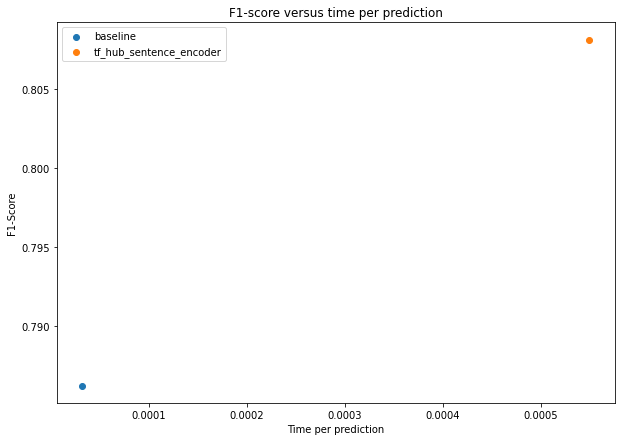

In [130]:

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
plt.scatter(baseline_time_per_pred, baseline_results["f1"], label="baseline")
plt.scatter(model_6_time_per_pred, model_6_results["f1"], label="tf_hub_sentence_encoder")
plt.legend()
plt.title("F1-score versus time per prediction")
plt.xlabel("Time per prediction")
plt.ylabel("F1-Score");

# THE END